
欢迎来到【LLM基础锻造厂】的第二站。
在我们的配套文章中，我们深入探讨了Attention机制的数学原理。

现在，是时候将这些抽象的公式，变成一幅幅看得见、摸得着的画面了。

本 Notebook 的核心使命只有一个：可视化。

我们将亲手实现Attention的核心逻辑，并利用matplotlib和seaborn等工具，将注意力分数、多头机制、以及位置编码，以最直观的方式呈现出来。

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


sns.set_theme(style="whitegrid")
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False    # 解决负号 '-' 显示为方块的问题

print("所有库已成功导入。")

所有库已成功导入。


# 注意力点积实现代码

In [2]:
def scaled_dot_product_attention(Q, K, V):
    """
    计算缩放点积注意力。
    
    Args:
        Q (torch.Tensor): 查询矩阵，形状 (seq_len, d_k)
        K (torch.Tensor): 键矩阵，形状 (seq_len, d_k)
        V (torch.Tensor): 值矩阵，形状 (seq_len, d_v)
        
    Returns:
        tuple: 包含输出张量和注意力权重矩阵的元组。
    """
    # 获取键向量的维度 d_k
    d_k = K.shape[-1]
    
    # 1.计算 Q 和 K.T 的点积，得到原始注意力分数
    attention_scores = Q @ K.transpose(-2, -1)
    
    # 2.进行缩放 
    scaled_attention_scores = attention_scores / np.sqrt(d_k)
    
    # 3.对缩放后的分数应用softmax，得到注意力权重
    attention_weights = F.softmax(scaled_attention_scores, dim=-1)
    
    # 4. 将权重与 V 矩阵相乘，得到最终的输出
    output = attention_weights @ V
    
    return output, attention_weights

# 探讨注意力


本节，我们探讨一下，我们的self-attention真的能注意到特殊的词吗？

我们输入句子"The robot picked up the ball because it was too heavy"，

观察"it" 注意的词

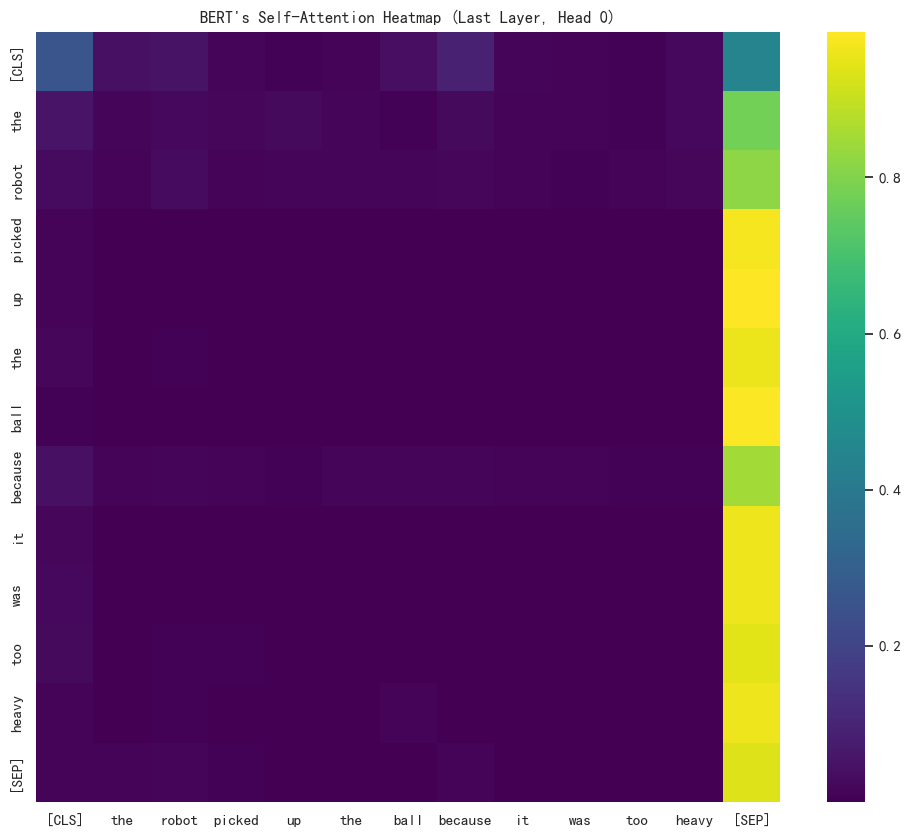

--- BERT中 'heavy' (索引 11) 的注意力分析 (Head 0) ---
最受'heavy'关注的前5个词是:
  - 词: '[SEP]',  注意力权重: 0.9603
  - 词: '[CLS]',  注意力权重: 0.0098
  - 词: 'ball',  注意力权重: 0.0089
  - 词: 'robot',  注意力权重: 0.0053
  - 词: 'because',  注意力权重: 0.0027


In [5]:
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 加载一个预训练好的BERT模型和分词器
model_name = 'bert-base-uncased' 
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True) 
model.eval() 

# 准备我们的句子 ---
sentence = "The robot picked up the ball because it was too heavy"
# 使用BERT的分词器进行处理
inputs = tokenizer(sentence, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])


with torch.no_grad():
    outputs = model(**inputs)
    attention_weights_all_heads = outputs.attentions[-1]


# 让我们选择一个头来观察，比如第0个头 (索引为0)
head_index = 0
attention_weights_head_0 = attention_weights_all_heads[0, head_index, :, :]

plt.figure(figsize=(12, 10))
sns.heatmap(
    attention_weights_head_0.numpy(),
    xticklabels=tokens,
    yticklabels=tokens,
    cmap='viridis'
)
plt.title(f"BERT's Self-Attention Heatmap (Last Layer, Head {head_index})")
plt.show()

# 精确分析'it'的注意力 
heavy_index = tokens.index('heavy')
# 提取'heavy'对所有其他词的注意力权重
heavy_attention = attention_weights_head_0[heavy_index, :]
# 找出最受'heavy'关注的词
top_k_values, top_k_indices = torch.topk(heavy_attention, k=5)

print(f"--- BERT中 'heavy' (索引 {heavy_index}) 的注意力分析 (Head {head_index}) ---")
print("最受'heavy'关注的前5个词是:")
for i in range(5):
    token_index = top_k_indices[i].item()
    attention_value = top_k_values[i].item()
    print(f"  - 词: '{tokens[token_index]}',  注意力权重: {attention_value:.4f}")

  居然全部关注'[SEP]','[CLS]', 这个和句意无关的标签！
  
 这是一个头，那其他头呢？

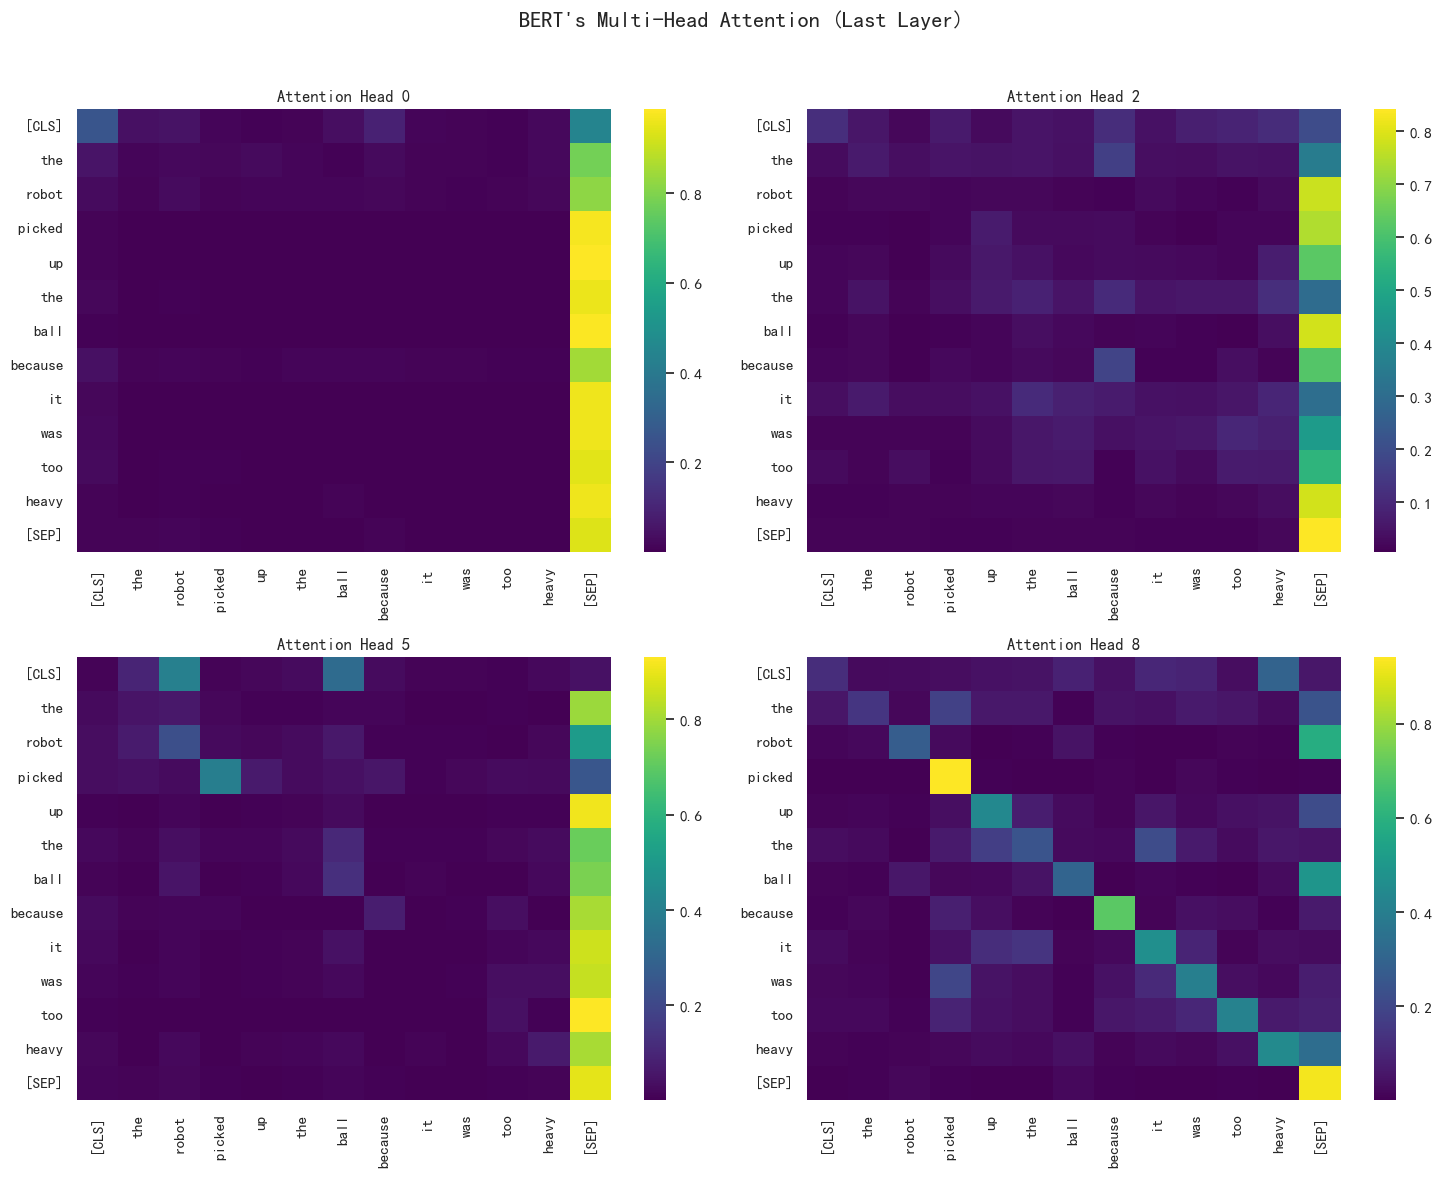

--- BERT中 'heavy' 的注意力分析 (跨多个头) ---

🎉 发现一个有趣的头: Head 0
   'heavy' 在这个头里，最关注的词是: 'ball' (权重: 0.0089)

🎉 发现一个有趣的头: Head 3
   'heavy' 在这个头里，最关注的词是: 'ball' (权重: 0.0224)

🎉 发现一个有趣的头: Head 5
   'heavy' 在这个头里，最关注的词是: 'ball' (权重: 0.0222)

🎉 发现一个有趣的头: Head 9
   'heavy' 在这个头里，最关注的词是: 'ball' (权重: 0.0403)

🎉 发现一个有趣的头: Head 11
   'heavy' 在这个头里，最关注的词是: 'robot' (权重: 0.0258)


In [6]:

num_heads = model.config.num_attention_heads 
heads_to_visualize = [0, 2, 5, 8] # 让我们再次挑选几个头

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("BERT's Multi-Head Attention (Last Layer)", fontsize=16)


axes = axes.flatten()

for i, head_index in enumerate(heads_to_visualize):
    # 提取当前头的注意力权重
    attention_weights_head = attention_weights_all_heads[0, head_index, :, :]
    
    # 在对应的子图上绘制热力图
    sns.heatmap(
        attention_weights_head.numpy(),
        xticklabels=tokens,
        yticklabels=tokens,
        cmap='viridis',
        ax=axes[i]
    )
    axes[i].set_title(f"Attention Head {head_index}")

plt.tight_layout(rect=[0, 0, 1, 0.96]) # 调整布局，为总标题留出空间
plt.show()



it_index = tokens.index('heavy')

print(f"--- BERT中 'heavy' 的注意力分析 (跨多个头) ---")
for head_index in range(num_heads):
    #提取当前头中，'heavy'对所有其他词的注意力权重
    heavy_attention = attention_weights_all_heads[0, head_index, heavy_index, :]
    # 找到最受'heavy'关注的那个词 (除了它自己和特殊token)
    
    # 我们先屏蔽掉 'heavy' 自己, [CLS], [SEP]
    heavy_attention[heavy_index] = 0
    heavy_attention[tokens.index('[CLS]')] = 0
    heavy_attention[tokens.index('[SEP]')] = 0

    top_value, top_index = torch.max(heavy_attention, dim=0)
    top_token = tokens[top_index.item()]
    
    # 让我们只打印那些真正关注了语义词的头
    if 'ball' in top_token or 'robot' in top_token:
        print(f"\n🎉 发现一个有趣的头: Head {head_index}")
        print(f"   'heavy' 在这个头里，最关注的词是: '{top_token}' (权重: {top_value.item():.4f})")

# cross attention

In [8]:

# 导入所需库
from transformers import T5Tokenizer, T5Model
import torch
import matplotlib.pyplot as plt
import seaborn as sns

print("--- 开始第二幕：解剖T5 ---")

# --- 1. 加载一个预训练好的T5模型和分词器 ---
model_name = 't5-small'
try:
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5Model.from_pretrained(model_name, output_attentions=True)
    model.eval()
    print(f"模型 '{model_name}' 加载成功。")
except Exception as e:
    print(f"加载模型失败，请检查网络和库。错误: {e}")
    # 如果加载失败，我们可以停止后续代码的执行
    raise e

# --- 2. 准备Encoder的输入，并获取其tokens ---
encoder_text = "I love you"
encoder_inputs = tokenizer(encoder_text, return_tensors='pt')
encoder_tokens = tokenizer.convert_ids_to_tokens(encoder_inputs['input_ids'][0])
print(f"Encoder的输入: '{encoder_text}' -> Tokens: {encoder_tokens}")


# --- 3. 准备Decoder的“标准答案”ID序列 ---
target_sentence = "Ich liebe dich"
# 我们将完整的德语目标句子，一次性地分词，得到“标准答案”的ID序列
# tokenizer会自动在末尾加上</s>
target_ids_full = tokenizer(target_sentence, return_tensors='pt').input_ids
print(f"Decoder的目标: '{target_sentence}'")


# --- 4. 模拟Decoder的自回归生成过程 ---
# 初始的Decoder输入，只有一个起始符<pad>
decoder_input_ids = tokenizer("<pad>", return_tensors="pt").input_ids

# 我们将存储每一步生成时，最后一个词的注意力分布
attention_storage = {}

# 逐个token地进行“闭卷模拟”
attention_storage = {}

# 5. 逐个token地进行“闭卷模拟”
for step in range(target_ids_full.shape[1]):
    with torch.no_grad():
        outputs = model(input_ids=encoder_inputs.input_ids, decoder_input_ids=decoder_input_ids)
        
        # outputs.cross_attentions 现在是一个元组，包含了6层的所有权重
        # cross_attentions[i] 的形状是 [1, 8, target_len, 4]
        
        last_token_attention_all_layers = [
            layer_attention[:, :, -1, :].squeeze(2) 
            for layer_attention in outputs.cross_attentions
        ] # 这是一个列表，包含了6个 [1, 8, 4] 的张量
        
        current_token_id = decoder_input_ids[0, -1].item()
        current_token = tokenizer.convert_ids_to_tokens([current_token_id])[0]
        
        attention_storage[f"{current_token} (step {step})"] = last_token_attention_all_layers
        
        if step < target_ids_full.shape[1]:
            next_token_id = target_ids_full[0, step]
            decoder_input_ids = torch.cat(
                [decoder_input_ids, torch.tensor([[next_token_id]])], dim=-1
            )

# --- 6. 终极分析：跨所有层、所有头的“地毯式搜索” ---
print("\n--- T5在“生成”过程中的跨语言注意力分析 (全层搜索) ---")

for token_name, all_layers_attention in attention_storage.items():
    if '<pad>' in token_name or '</s>' in token_name:
        continue
        
    print(f"\n当Decoder正在生成 '{token_name}' 时:")
    
    # 遍历每一层
    for layer_index, layer_attention in enumerate(all_layers_attention):
        num_heads = model.config.num_attention_heads
        
        # 遍历这一层的每一个头
        for head_index in range(num_heads):
            head_attention = layer_attention[0, head_index, :]
            top_value, top_index = torch.max(head_attention, dim=0)
            top_token = encoder_tokens[top_index.item()]
            
            # 我们只寻找那个最“惊艳”的、几乎是1对1的对齐信号
            if top_value > 0.95 and 'love' in top_token and 'lieb' in token_name:
                 print(f"  - 🔥🔥🔥【重大发现】在【第 {layer_index} 层】的【Head {head_index}】中:")
                 print(f"       它以 {top_value.item():.4f} 的压倒性权重, 精准地将 '{token_name}' 锁定在了 '{top_token}' 身上！")

--- 开始第二幕：解剖T5 ---
模型 't5-small' 加载成功。
Encoder的输入: 'I love you' -> Tokens: ['▁I', '▁love', '▁you', '</s>']
Decoder的目标: 'Ich liebe dich'

--- T5在“生成”过程中的跨语言注意力分析 (全层搜索) ---

当Decoder正在生成 '▁Ich (step 1)' 时:

当Decoder正在生成 '▁liebe (step 2)' 时:
  - 🔥🔥🔥【重大发现】在【第 0 层】的【Head 3】中:
       它以 0.9905 的压倒性权重, 精准地将 '▁liebe (step 2)' 锁定在了 '▁love' 身上！
  - 🔥🔥🔥【重大发现】在【第 1 层】的【Head 5】中:
       它以 0.9720 的压倒性权重, 精准地将 '▁liebe (step 2)' 锁定在了 '▁love' 身上！
  - 🔥🔥🔥【重大发现】在【第 1 层】的【Head 7】中:
       它以 0.9918 的压倒性权重, 精准地将 '▁liebe (step 2)' 锁定在了 '▁love' 身上！

当Decoder正在生成 '▁dich (step 3)' 时:



这同时揭示：不同层级的注意力，扮演着不同的角色

# 位置编码


In [2]:
import torch
import numpy as np

def get_positional_encoding(seq_len, d_model):
    """
    生成位置编码矩阵。

    Args:
        seq_len (int): 序列的最大长度。
        d_model (int): 模型的维度 (词嵌入的维度)。

    Returns:
        torch.Tensor: 位置编码矩阵，形状 (seq_len, d_model)。
    """
    
    # 创建一个空的PE矩阵
    pe = torch.zeros(seq_len, d_model)
    

    
    # 创建位置张量 position
    # 形状为 [seq_len, 1]
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)

    # 创建频率项 div_term (这是公式的核心)
    # 公式: 1 / (10000^(2i/d_model))
    # 提示: i 的取值是 0, 1, 2, ..., d_model/2 - 1
    # 所以 2i 的取值是 0, 2, 4, ...
    # torch.arange(0, d_model, 2) 可以生成 2i
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

    # 计算偶数维度的sin值
    # 对pe矩阵进行切片 pe[:, 0::2]，即所有行，从0开始，步长为2的列
    pe[:, 0::2] = torch.sin(position * div_term)

    # 计算奇数维度的cos值
    # 对pe矩阵进行切片 pe[:, 1::2]
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe

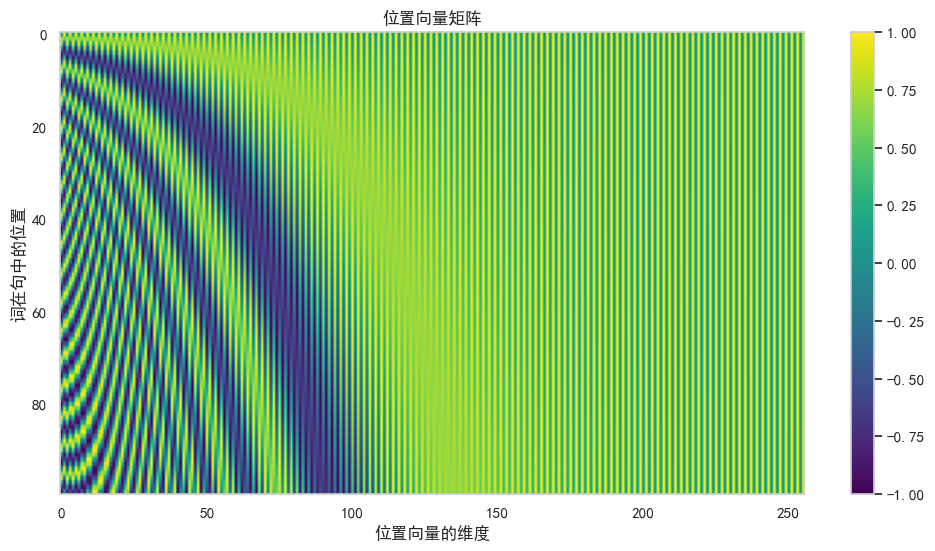

In [19]:
MAX_LEN = 100  # 我们看前100个位置
D_MODEL = 256 # 我们设置一个256维的模型

# 生成位置编码
pe_matrix = get_positional_encoding(MAX_LEN, D_MODEL)


plt.figure(figsize=(12, 6))
plt.imshow(pe_matrix, aspect='auto', cmap='viridis')
plt.grid(False)
plt.title("位置向量矩阵")
plt.xlabel("位置向量的维度")
plt.ylabel("词在句中的位置")
plt.colorbar()
plt.show()

纵轴代表词在序列中的位置，横轴代表向量的维度。

仔细观察，你会发现没有任何两行（代表两个不同的位置）的颜色模式是完全相同的

图像的左侧（低位维度），颜色变化非常剧烈，形成了密集的“波纹”。

这正是我们之前讨论的高频信号，它对分辨相邻位置极其敏感。

而图像的右侧（高位维度），颜色变化则非常平缓，形成了大片的“色块”，这正是低频信号，用于编码一个词在句子中的大致轮廓。

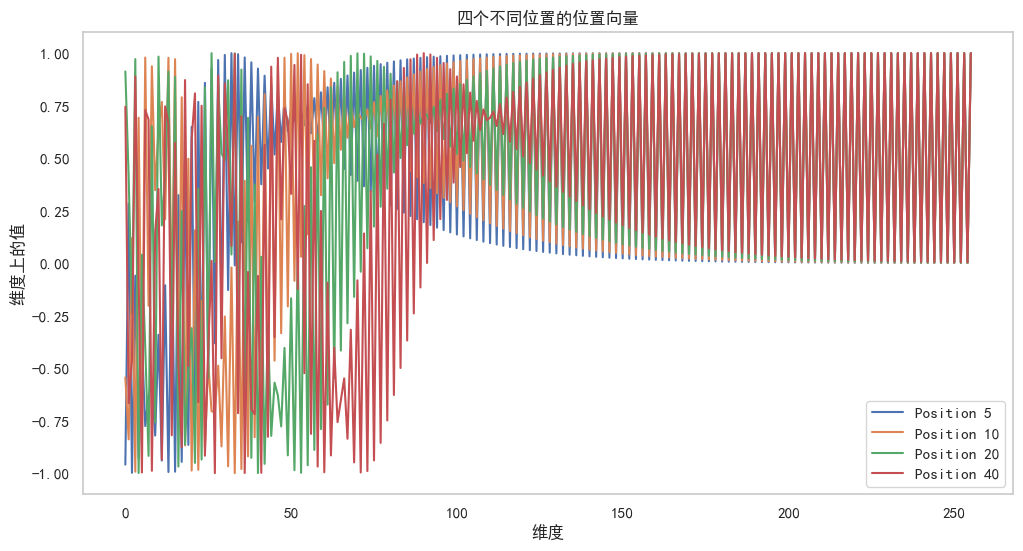

In [28]:
plt.figure(figsize=(12, 6))
positions_to_plot = [5,10,20,40]
for pos in positions_to_plot:
    plt.plot(pe_matrix[pos].numpy(), label=f"Position {pos}")
plt.title("四个不同位置的位置向量")
plt.grid(False)
plt.xlabel("维度")
plt.ylabel("维度上的值")
plt.legend()
plt.show()

让我们聚焦于向量的前半部分（维度0到50），看看这些高频信号的真实面貌。

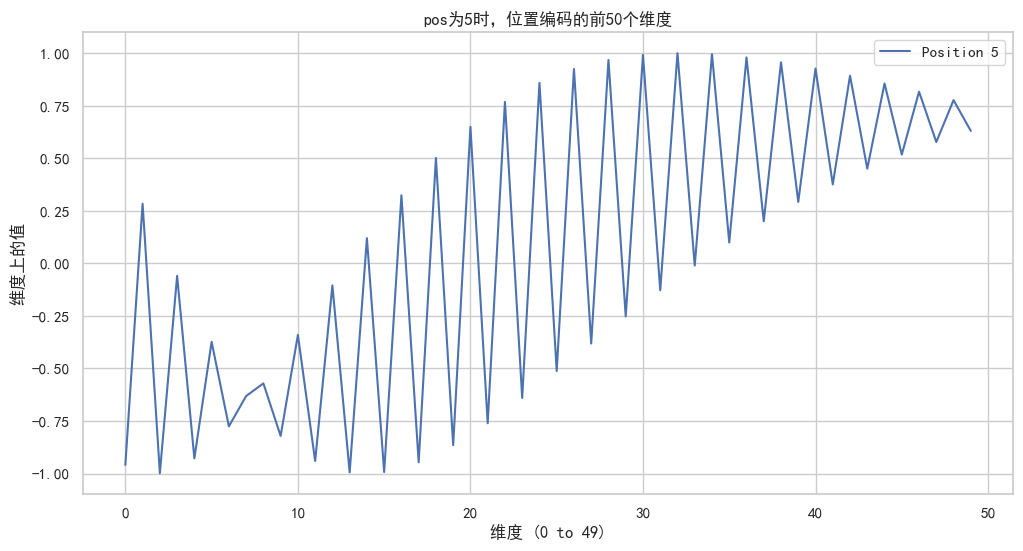

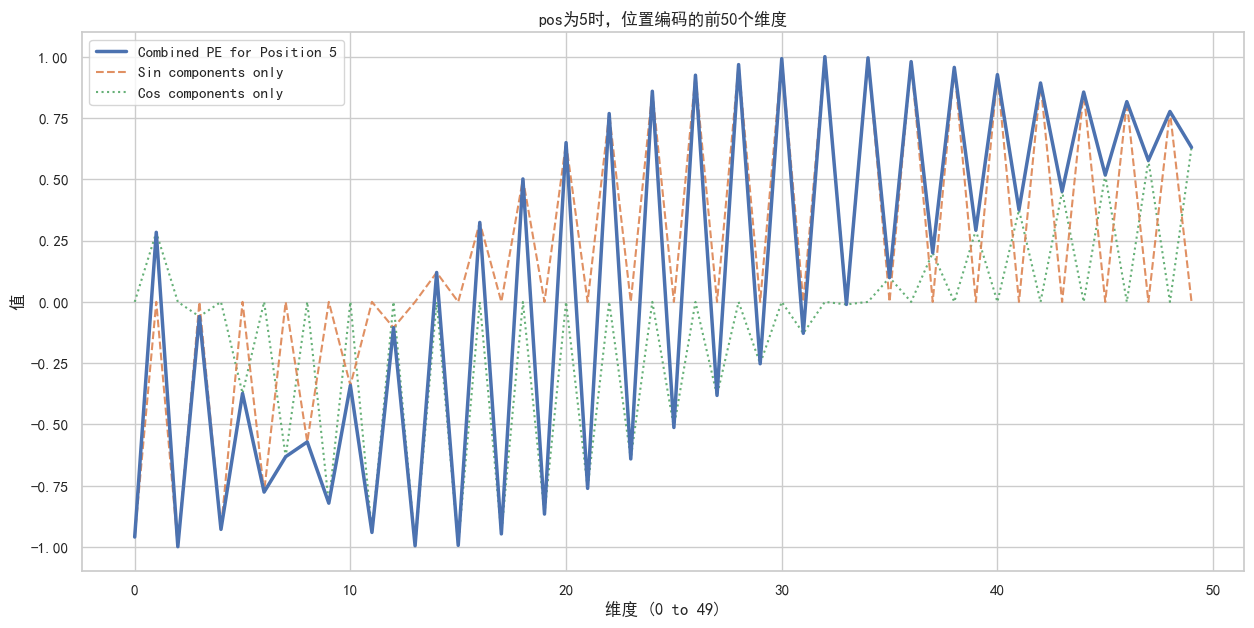

In [29]:
plt.figure(figsize=(12, 6))
positions_to_plot = [5]
dimensions_to_plot = 50 # 我们只看前50个维度

for pos in positions_to_plot:
    # 我们只取出pe_matrix的前50列来进行绘制
    plt.plot(pe_matrix[pos, :dimensions_to_plot].numpy(), label=f"Position {pos}")

plt.title("pos为5时，位置编码的前50个维度")
plt.xlabel(f"维度 (0 to {dimensions_to_plot-1})")
plt.ylabel("维度上的值")
plt.legend()
plt.show()


pos_to_dissect = 5
#dimensions_to_plot = 50

pe_vector = pe_matrix[pos_to_dissect, :dimensions_to_plot]

sin_only = torch.zeros_like(pe_vector)
sin_only[0::2] = pe_vector[0::2]

cos_only = torch.zeros_like(pe_vector)
cos_only[1::2] = pe_vector[1::2]

plt.figure(figsize=(15, 7))

# 绘制完整的向量（蓝色实线）
plt.plot(pe_vector.numpy(), label=f"Combined PE for Position {pos_to_dissect}", linewidth=2.5, zorder=3) # zorder让它在最上层

# 绘制sin分量（橙色虚线）
plt.plot(sin_only.numpy(), label="Sin components only", linestyle='--', alpha=0.9, zorder=2)

# 绘制cos分量（绿色点线）
plt.plot(cos_only.numpy(), label="Cos components only", linestyle=':', alpha=0.9, zorder=1)

plt.title("pos为5时，位置编码的前50个维度")
plt.xlabel(f"维度 (0 to {dimensions_to_plot-1})")
plt.ylabel("值")
plt.legend()
plt.grid(True)
plt.show()

接下来，让我们把“放大镜”移到向量的后半部分（维度200到255），看看那些“宇宙时钟”的真实状态。

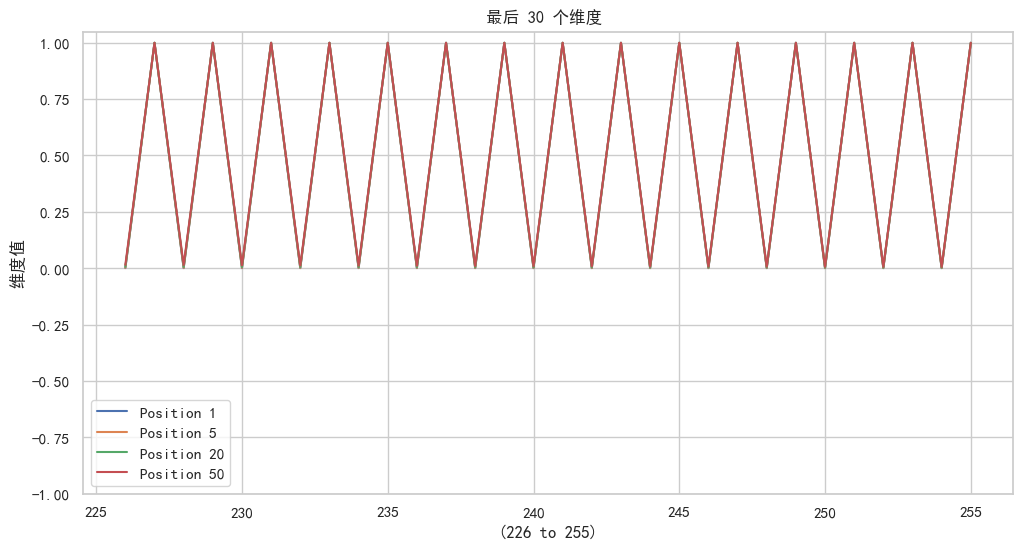

In [27]:
plt.figure(figsize=(12, 6))
positions_to_plot = [1, 5, 20, 50]
start_dim = 226# 从第200个维度开始

for pos in positions_to_plot:
    # 我们只取出pe_matrix的后半部分来进行绘制
    plt.plot(
        range(start_dim, D_MODEL), # 确保X轴的标签是正确的
        pe_matrix[pos, start_dim:].numpy(), 
        label=f"Position {pos}"
    )

plt.title(f"最后 {D_MODEL-start_dim} 个维度 ")
plt.xlabel(f"({start_dim} to {D_MODEL-1})")
plt.ylabel("维度值")
# 设置Y轴的范围，以便更清晰地看到微小的变化
plt.ylim(-1, 1.05) 
plt.legend()
plt.show()



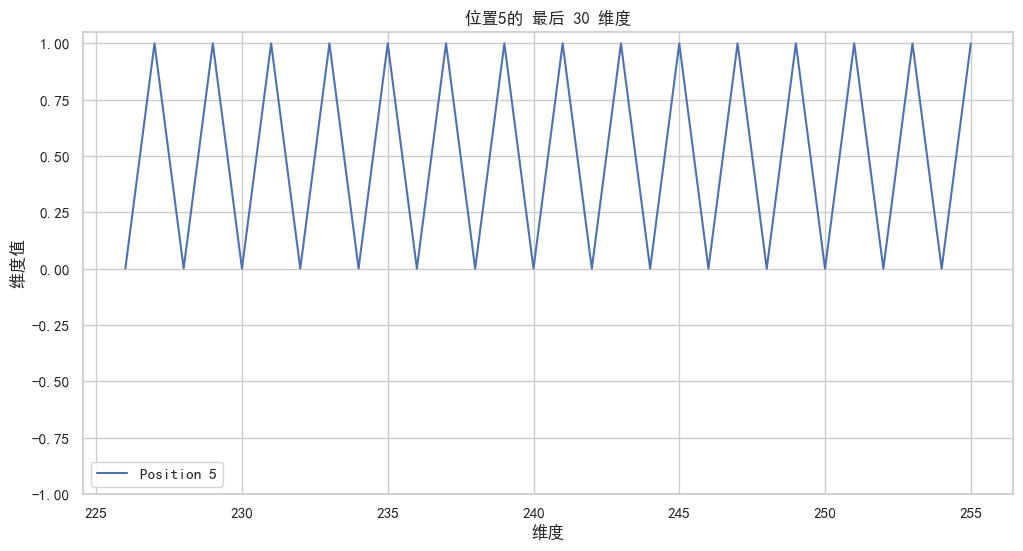

In [32]:
plt.figure(figsize=(12, 6))
positions_to_plot = [5]
start_dim = 226 

for pos in positions_to_plot:
    plt.plot(
        range(start_dim, D_MODEL), # 确保X轴的标签是正确的
        pe_matrix[pos, start_dim:].numpy(), 
        label=f"Position {pos}"
    )

plt.title(f"位置5的 最后 {D_MODEL-start_dim} 维度")
plt.xlabel("维度")
plt.ylabel("维度值")
# 设置Y轴的范围，以便更清晰地看到微小的变化
plt.ylim(-1, 1.05) 
plt.legend()
plt.show()




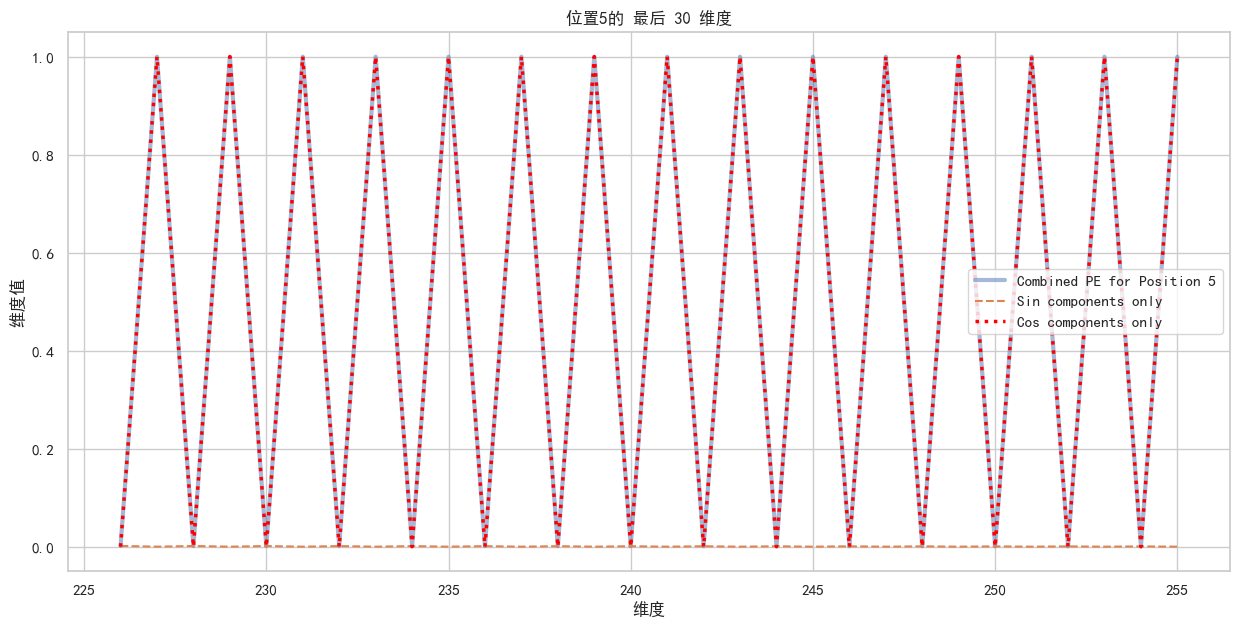

In [31]:
pos_to_dissect = 5
start_dim = 226 

pe_vector_part = pe_matrix[pos_to_dissect, start_dim:]

sin_only = torch.zeros_like(pe_vector_part)
# 注意！这里的切片索引也要从0开始，因为pe_vector_part是新的短向量
sin_only[0::2] = pe_vector_part[0::2] 

cos_only = torch.zeros_like(pe_vector_part)
cos_only[1::2] = pe_vector_part[1::2]

plt.figure(figsize=(15, 7))

# 绘制完整的向量（蓝色实线，我们把它放到最底层）
plt.plot(range(start_dim, D_MODEL), pe_vector_part.numpy(), 
         label=f"Combined PE for Position {pos_to_dissect}", linewidth=3, alpha=0.5, zorder=1)

# 绘制sin分量（橙色虚线）
plt.plot(range(start_dim, D_MODEL), sin_only.numpy(), 
         label="Sin components only", linestyle='--', zorder=2)

# --- 这是关键：让cos在最顶层，并给它一个醒目的颜色和标记 ---
plt.plot(range(start_dim, D_MODEL), cos_only.numpy(), 
         label="Cos components only", linestyle=':', color='red', linewidth=2.5, zorder=3)

plt.title(f"位置5的 最后 {D_MODEL-start_dim} 维度")
plt.xlabel("维度")
plt.ylabel("维度值")
plt.legend()
plt.grid(True)
plt.show()

“位置12-10”的差值向量，与“位置14-12”的差值向量，其余弦相似度为: 0.202669


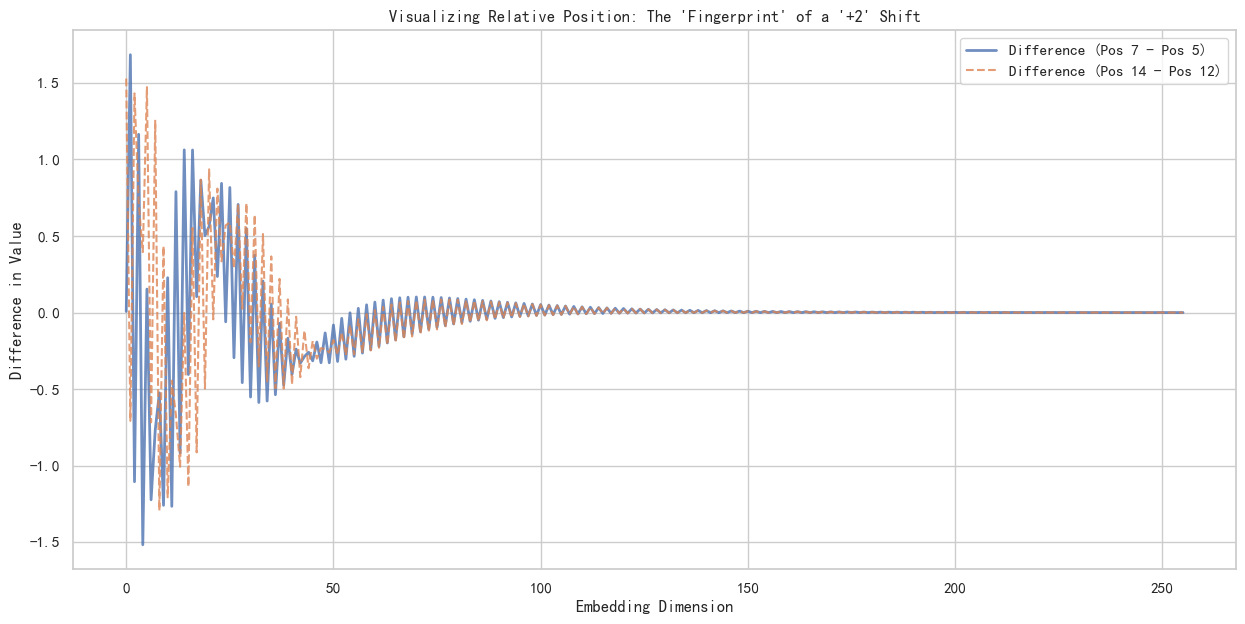

In [15]:
# --- 圣杯挑战：可视化相对位置 ---

# 1. 计算两对“差值向量”
diff_A = pe_matrix[12] - pe_matrix[10]
diff_B = pe_matrix[14] - pe_matrix[12]

# 2. 计算这两个“差值向量”之间的余弦相似度
#    如果它们相似，这个值应该非常接近1.0
similarity = F.cosine_similarity(diff_A.unsqueeze(0), diff_B.unsqueeze(0))

print(f"“位置12-10”的差值向量，与“位置14-12”的差值向量，其余弦相似度为: {similarity.item():.6f}")

# 3. 将这两个“差值向量”的波形绘制出来，进行视觉对比
plt.figure(figsize=(15, 7))

plt.plot(diff_A.numpy(), label="Difference (Pos 7 - Pos 5)", linewidth=2, alpha=0.8)
plt.plot(diff_B.numpy(), label="Difference (Pos 14 - Pos 12)", linestyle='--', alpha=0.8)

plt.title("Visualizing Relative Position: The 'Fingerprint' of a '+2' Shift")
plt.xlabel("Embedding Dimension")
plt.ylabel("Difference in Value")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
pos_pairs = [(5, 7), (12, 14), (50, 52)]

print("--- 验证相对位移'+2'的几何关系是否恒定 ---")

for pos1, pos2 in pos_pairs:
    # 提取对应位置的向量
    vec1 = pe_matrix[pos1]
    vec2 = pe_matrix[pos2]
    
    # 计算它们之间的余弦相似度
    similarity = F.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0))
    
    print(f"PE(pos={pos1}) 和 PE(pos={pos2}) 之间的余弦相似度: {similarity.item():.8f}")

print("\n结论：无论在序列的哪个位置，相隔2个单位的两个位置编码向量，它们之间的夹角（几何关系）是完全恒定的！")
print("这无可辩驳地证明了，模型可以通过一个固定的线性变换，来推断相对位置。")

--- 验证相对位移'+2'的几何关系是否恒定 ---
PE(pos=5) 和 PE(pos=7) 之间的余弦相似度: 0.90237975
PE(pos=12) 和 PE(pos=14) 之间的余弦相似度: 0.90237963
PE(pos=50) 和 PE(pos=52) 之间的余弦相似度: 0.90237963

结论：无论在序列的哪个位置，相隔2个单位的两个位置编码向量，它们之间的夹角（几何关系）是完全恒定的！
这无可辩驳地证明了，模型可以通过一个固定的线性变换，来推断相对位置。


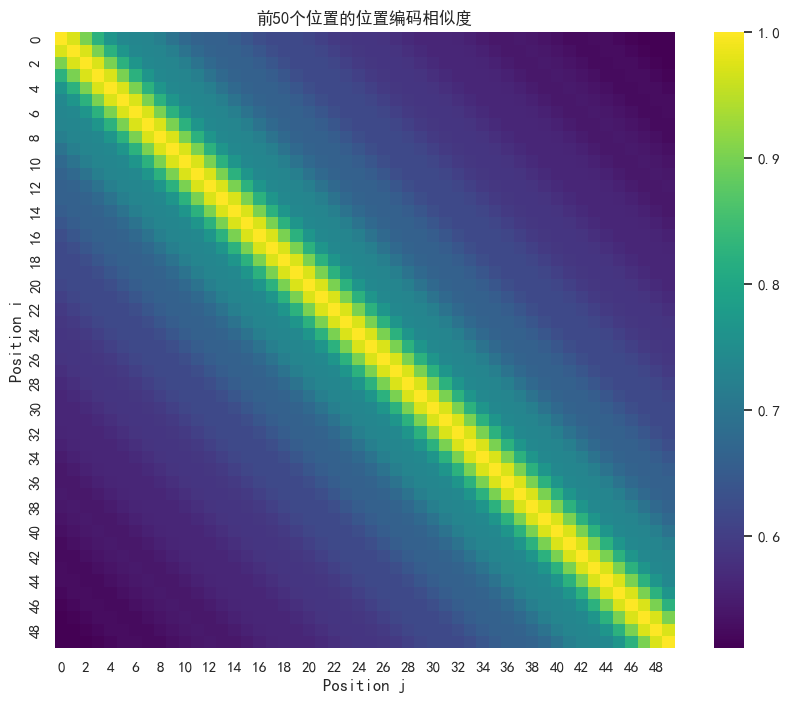

In [34]:
num_positions = 50
pe_subset = pe_matrix[:num_positions, :] # 形状 [50, 256]

# 2. 计算这50个位置编码向量两两之间的余弦相似度
#    F.cosine_similarity可以高效地计算矩阵行与行之间的相似度
#    我们需要将矩阵复制一份，然后计算 pe_subset 和 pe_subset 之间的相似度
#    pe_subset.unsqueeze(1) -> [50, 1, 256]
#    pe_subset.unsqueeze(0) -> [1, 50, 256]
#    广播机制会自动计算所有对之间的相似度
similarity_matrix = F.cosine_similarity(pe_subset.unsqueeze(1), pe_subset.unsqueeze(0), dim=-1)

# 3. 绘制这张“关系图谱”的热力图
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix.numpy(), cmap='viridis')
plt.title("前50个位置的位置编码相似度")
plt.xlabel("Position j")
plt.ylabel("Position i")
plt.show()